# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs_f0 = load_data(data_dir, star_file, True)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  5.224998474121094
load_data: FFT of data, time:  8.286238193511963


In [4]:
print(imgs_f0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = 10000
imgs_f = imgs_f0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Create the grids

In [7]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [8]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [9]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


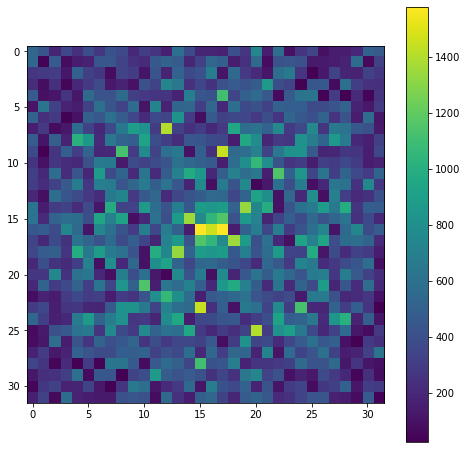

In [10]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

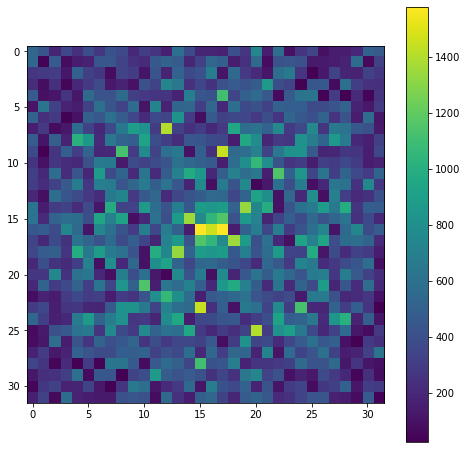

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

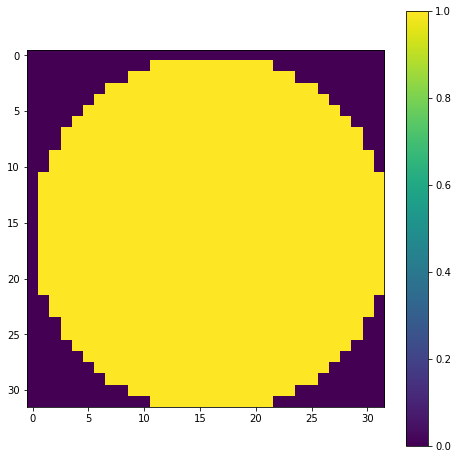

In [12]:
centre = (0,0,0)
radius = 0.05
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [13]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [14]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [15]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0], sigma=1)
print(time.time()-start)
print(ll.shape)

1.5179388523101807
(32, 32, 32)


In [16]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma=1)
print(time.time()-start)
print(ll.shape)

2.175039291381836
(32, 32, 32)


### Ab initio

In [17]:
x_grid[0]*x_grid[1]/2

0.05021972132474

In [18]:
x_grid[0]

0.00313873258279625

0.1
1.1
0.1


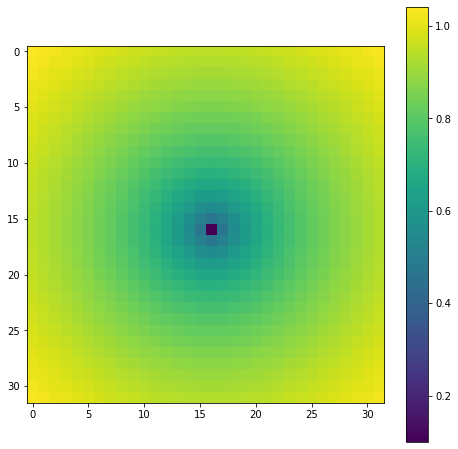

In [19]:
P = get_preconditioner(x_grid) 
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 0.1
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

In [28]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [43]:
#sys.stdout = sys.__stdout__

  cg iter 0 ||r|| = 0.000388370609398941
  cg iter 4 ||r|| = 2.302486137936544e-05


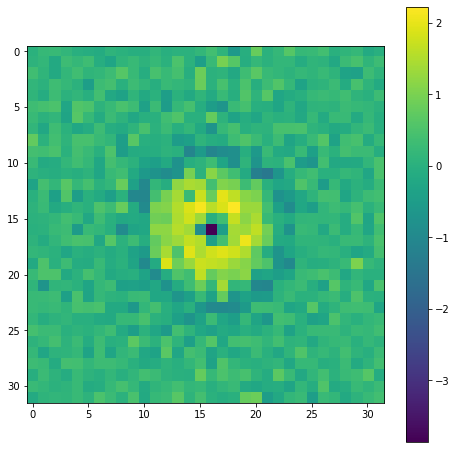

Iter  0
  Time orientations sampling = 2.084620475769043
  cg iter 0 ||r|| = 0.0005636136787317474
  cg iter 4 ||r|| = 2.699278728456442e-05
  Time vol optimisation = 9.16491436958313
2022-02-11 17:42:45.531750
  nx = 20


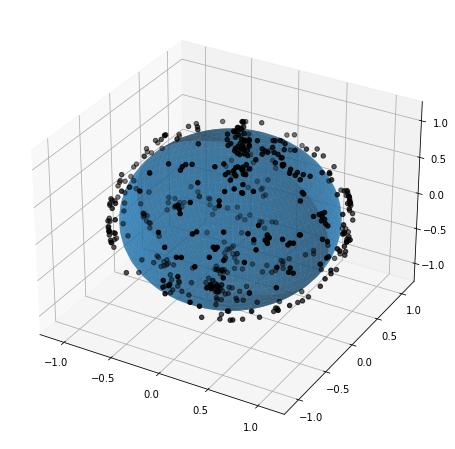

Iter  1
  Time orientations sampling = 2.0859315395355225
  cg iter 0 ||r|| = 0.002074754565951783
  cg iter 38 ||r|| = 2.9684125214038982e-05
  Time vol optimisation = 12.022844552993774
Iter  2
  Time orientations sampling = 2.091193675994873
  cg iter 0 ||r|| = 0.002660023063853647
  cg iter 50 ||r|| = 4.6583741170168e-05
  cg iter 78 ||r|| = 2.920208415178682e-05
  Time vol optimisation = 13.312673330307007
Iter  3
  Time orientations sampling = 2.1157729625701904
  cg iter 0 ||r|| = 0.0028288882683107654
  cg iter 50 ||r|| = 3.970944376243956e-05
  cg iter 71 ||r|| = 2.7865200706944325e-05
  Time vol optimisation = 13.113952159881592
Iter  4
  Time orientations sampling = 2.12201189994812
  cg iter 0 ||r|| = 0.0029183882877266893
  cg iter 50 ||r|| = 0.00011543265169960027
  cg iter 100 ||r|| = 4.414078711035197e-05
  cg iter 150 ||r|| = 3.983926457848771e-05
  cg iter 159 ||r|| = 2.987001035871051e-05
  Time vol optimisation = 15.93773341178894
Iter  5
  Time orientations samplin

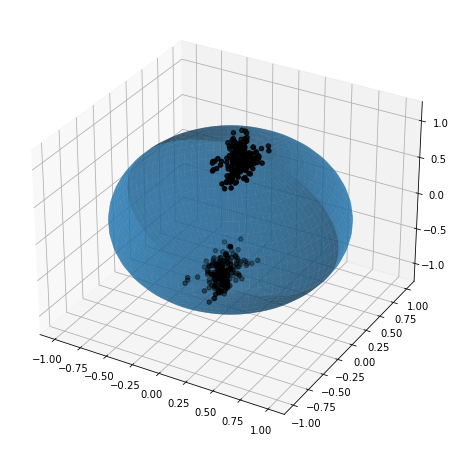

Iter  9
  Time orientations sampling = 2.100083351135254
  cg iter 0 ||r|| = 0.00421455027159792
  cg iter 50 ||r|| = 5.075801563936376e-05
  cg iter 100 ||r|| = 2.9810784719685673e-05
  Time vol optimisation = 16.128429174423218
Iter  10
  Time orientations sampling = 2.1419577598571777
  cg iter 0 ||r|| = 0.004192421884034786
  cg iter 50 ||r|| = 4.77730908396914e-05
  cg iter 100 ||r|| = 4.298959972966472e-05
  cg iter 106 ||r|| = 2.8068145884786276e-05
  Time vol optimisation = 16.296099185943604
Iter  11
  Time orientations sampling = 2.1379082202911377
  cg iter 0 ||r|| = 0.004296468049851324
  cg iter 50 ||r|| = 6.710855184680917e-05
  cg iter 100 ||r|| = 4.315134059197169e-05
  cg iter 107 ||r|| = 2.7787012376445324e-05
  Time vol optimisation = 16.335939407348633
Iter  12
  Time orientations sampling = 2.1322243213653564
  cg iter 0 ||r|| = 0.004157499975845543
  cg iter 50 ||r|| = 0.0014721918439637813
  cg iter 100 ||r|| = 0.0015342550034208773
  cg iter 150 ||r|| = 0.001428

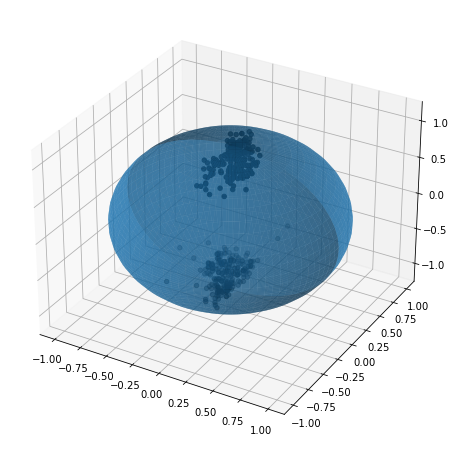

Iter  17
  Time orientations sampling = 2.166424512863159
  cg iter 0 ||r|| = 0.004332161350318693
  cg iter 50 ||r|| = 0.0004931823148526927
  cg iter 100 ||r|| = 0.00043588187155112695
  cg iter 150 ||r|| = 0.00041328328097512584
  cg iter 200 ||r|| = 0.0004247850345653769
  cg iter 250 ||r|| = 0.0003893528421301949
  cg iter 300 ||r|| = 0.00036517423658313547
  cg iter 350 ||r|| = 0.00034204025613517107
  cg iter 400 ||r|| = 0.00031828595038724933
  cg iter 450 ||r|| = 0.0002986804663886567
  cg iter 500 ||r|| = 0.0002814364861686881
  cg iter 550 ||r|| = 0.0002743118982787717
  cg iter 600 ||r|| = 0.0002548474118886015
  cg iter 650 ||r|| = 0.00024091170065106517
  cg iter 700 ||r|| = 0.0002319191401490376
  cg iter 750 ||r|| = 0.00021567103537471226
  cg iter 800 ||r|| = 0.00020506738953282507
  cg iter 850 ||r|| = 0.0001938877712579486
  cg iter 900 ||r|| = 0.00018000108715440183
  cg iter 950 ||r|| = 0.00016998370864198934
  cg iter 1000 ||r|| = 0.0001641267579721513
  cg iter 1

KeyboardInterrupt: 

In [265]:
N_samples = 40000
N_iter = 10000

dr = 0.005
#dr = 0.003
#radius = 0.01
radius = 0.03
alpha = 1e-6
#alpha = 1.1e-6

use_sgd = False

N_cg_iter = 10000
eps_cg = 3e-5

N_sgd_iter = 151
batch_size = 1000
#learning_rate = 1000
learning_rate = 10000
P = None

if use_sgd:
    N_vol_iter = N_sgd_iter
else:
    N_vol_iter = N_cg_iter

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])

sigma_noise = estimate_real_noise(jnp.abs(imgs_f))

v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_cg, 'tri', True, True, True, out_dir)

In [ ]:
v_rec.shape

In [ ]:
plot_angles(angles_rec[:2000])

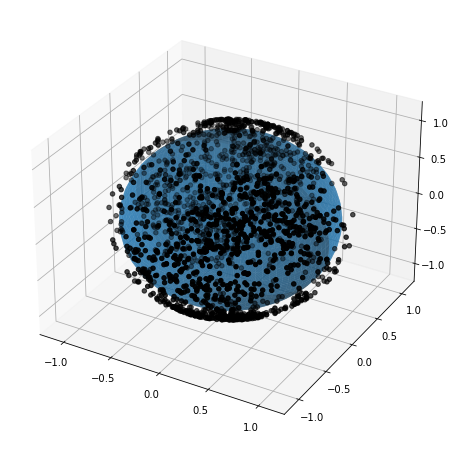

In [194]:
plot_angles(angles_rec[:2000])

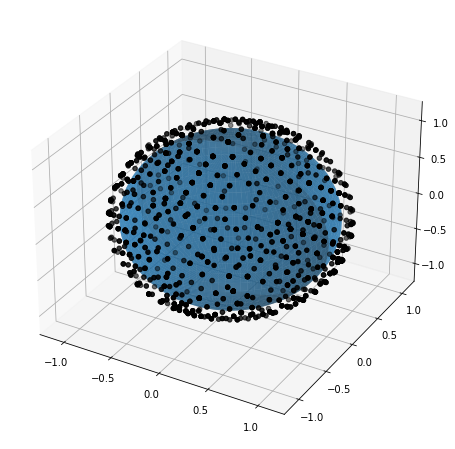

In [30]:
plot_angles(angles[:2000])

### CG

In [50]:
alpha = 1e-4
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))
#sigma_noise = jnp.max(sigma_noise) * jnp.ones(sigma_noise.shape)

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 101

#N2 = jnp.floor(N/2).astype(jnp.int64)
N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_rec[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape, sigma_noise)

In [51]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 2.229473759128272e-05
  cg iter 50 ||r|| = 5.431257166781235e-07
  cg iter 100 ||r|| = 3.6602226546659477e-07


In [52]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vcg1, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))/(nx*nx))

Final loss function (over all data) =  2.2127388709015983


In [39]:
l2sq(vcg1)*alpha/2

DeviceArray(0.5374013, dtype=float64)

In [295]:
#sgd_loss_func(vcg1, jnp.arange(N))

In [296]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

In [40]:
i = 110
s0 = slice_func(v_rec, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

NameError: name 'v_rec' is not defined

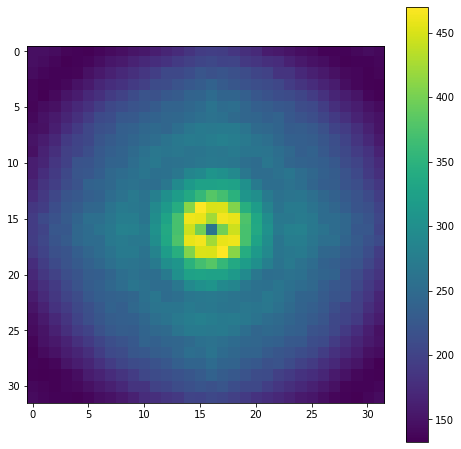

In [41]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))); plt.colorbar()

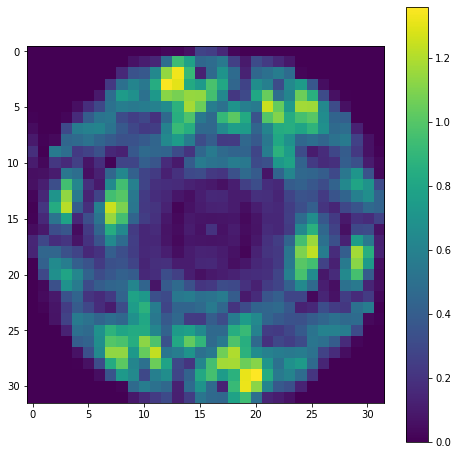

In [42]:
i = 100
s0 = slice_func(vcg1, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

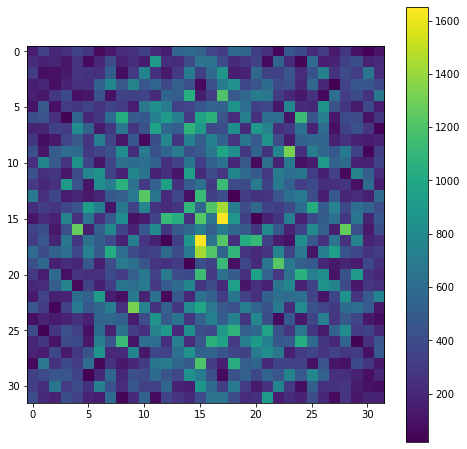

In [43]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[i]).reshape(nx,nx))); plt.colorbar()

In [44]:
resid = s0 - imgs_f[i]
d = jnp.real(jnp.conj(resid)*resid)/(2*sigma_noise**2)

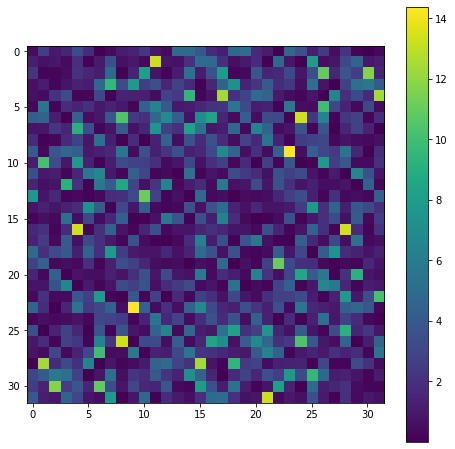

In [45]:
plt.imshow(jnp.fft.fftshift(d.reshape([32,32]))); plt.colorbar()

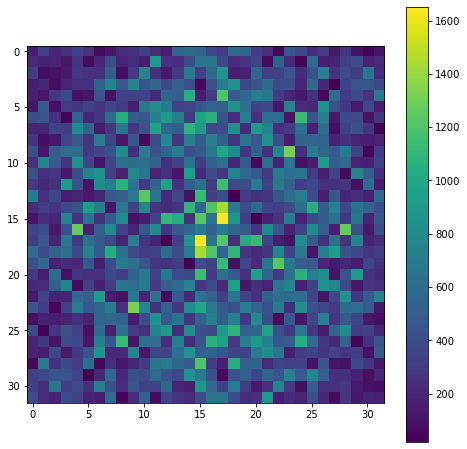

In [46]:
plt.imshow(jnp.abs(jnp.fft.fftshift(resid.reshape([32,32])))); plt.colorbar()

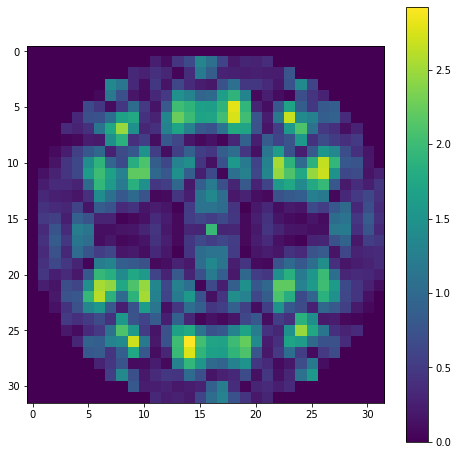

In [47]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

In [48]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec))))
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

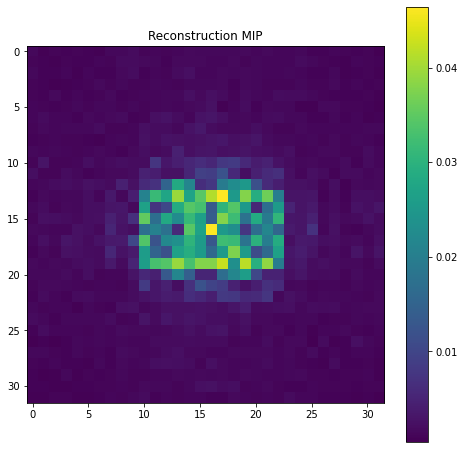

In [49]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [319]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

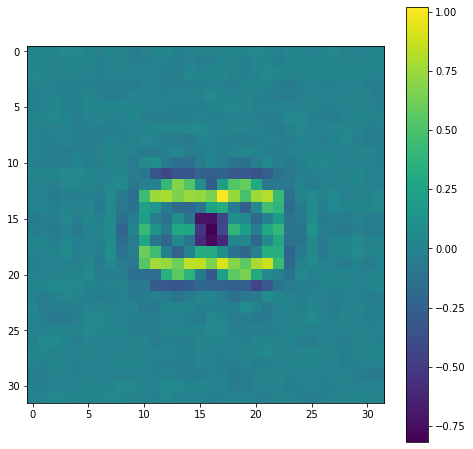

In [320]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

In [321]:
verr = vcg1 - v_rec
plt.imshow(jnp.abs(jnp.fft.fftshift(verr[0,:,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [322]:
jnp.max(jnp.abs(vcg1))

DeviceArray(116.88976, dtype=float64)

In [323]:
jnp.max(jnp.abs(v_rec))

NameError: name 'v_rec' is not defined

### Write volume to file

In [324]:
with mrcfile.new('../data/reconstruction_data_32_cg.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### CG - choosing $\alpha$

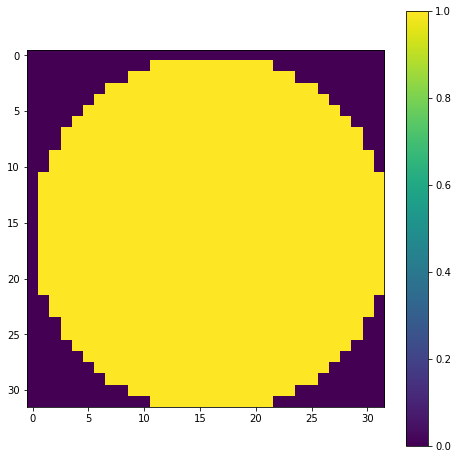

In [17]:
centre = (0,0,0)
radius = 0.05
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [107]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

Estimate the noise:

In [108]:
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)

sigma noise min = 132.62229570605956
sigma noise max = 470.02147341034373
sigma noise mean = 224.97894368229134


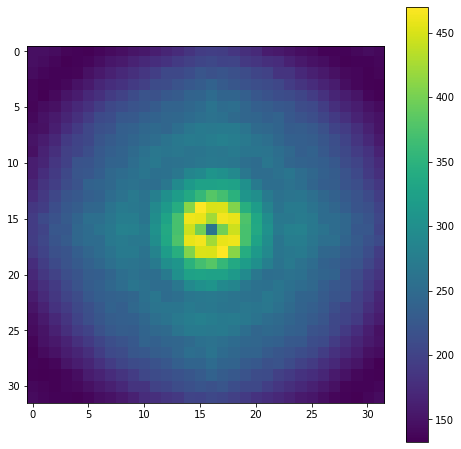

In [109]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [21]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [232]:
N_iter = 50100
eps = 3e-5
#eps = 1e-3
v0 = jnp.zeros([nx,nx,nx])* 1j
alphas = [1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
vcgs = []
fids = []
regs = []
losss = []

In [233]:
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_rec, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = fid_func_sum(vcg, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = 1/2*alpha*l2sq(vcg)/(nx*nx)
    loss = loss_func_sum(vcg, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-07
  cg iter 0 ||r|| = 0.004271558655686043
  cg iter 50 ||r|| = 0.0012775857225508953
  cg iter 100 ||r|| = 0.0009660506082206739
  cg iter 150 ||r|| = 0.000680684645898567
  cg iter 200 ||r|| = 0.00046833886033570003
  cg iter 250 ||r|| = 0.00034223597218694545
  cg iter 300 ||r|| = 0.00025404683931782126
  cg iter 350 ||r|| = 0.00020962575002486024
  cg iter 400 ||r|| = 0.00018240523070892957
  cg iter 450 ||r|| = 0.00016128019034050494
  cg iter 500 ||r|| = 0.0001396772739086308
  cg iter 550 ||r|| = 0.0001230442344456226
  cg iter 600 ||r|| = 0.00011223213525701607
  cg iter 650 ||r|| = 0.00010381812447481026
  cg iter 700 ||r|| = 9.621248720008203e-05
  cg iter 750 ||r|| = 9.419812645554647e-05
  cg iter 800 ||r|| = 8.972034588113889e-05
  cg iter 850 ||r|| = 8.405087791145382e-05
  cg iter 900 ||r|| = 7.688786880044451e-05
  cg iter 950 ||r|| = 8.077745381395095e-05
  cg iter 1000 ||r|| = 7.233262775729706e-05
  cg iter 1050 ||r|| = 6.662657155689659e-05
  cg iter 110

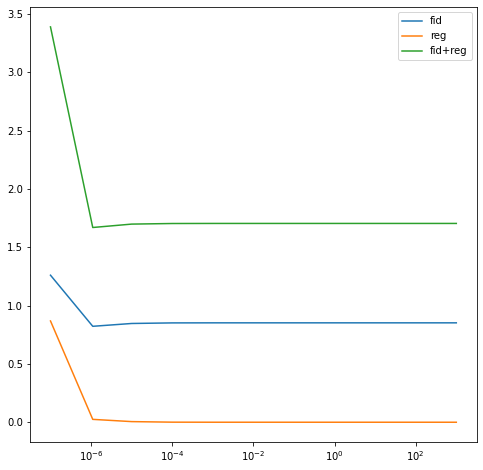

In [266]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

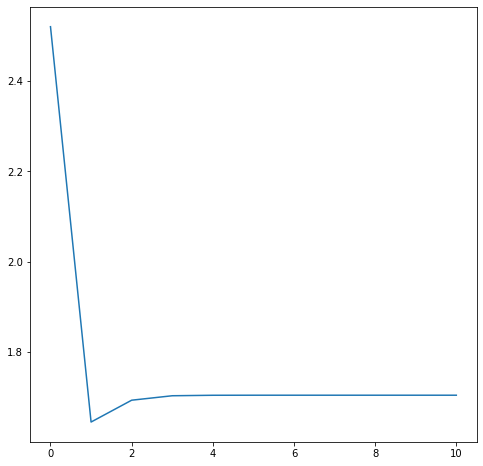

In [238]:
plt.plot(fids)

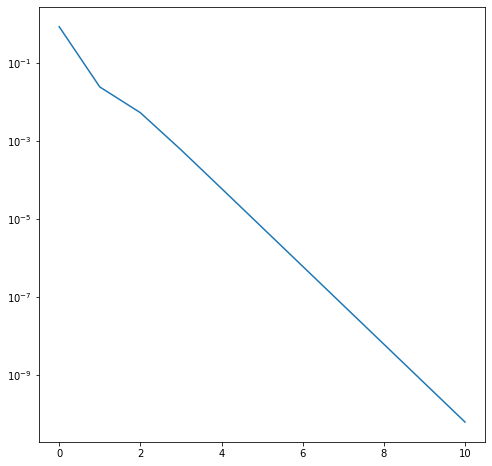

In [239]:
plt.semilogy(regs)

In [242]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

Pixel-wise loss for the best reconstruction:

In [243]:
fids[1]

DeviceArray(1.64438328, dtype=float64)

In [244]:
fids[10]

DeviceArray(1.70381921, dtype=float64)

In [245]:
jnp.mean(pw_fid)

DeviceArray(1.77694508, dtype=float64)

In [267]:
alpha_idx

0

In [269]:
alphas[alpha_idx]

DeviceArray(1.e-07, dtype=float64)

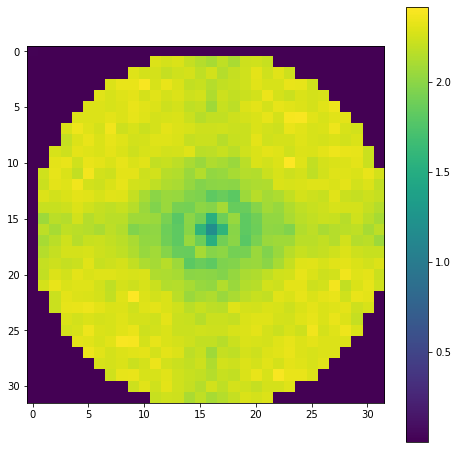

In [247]:
pw_fid = pixel_wise_fid_fun(vcgs[alpha_idx], slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

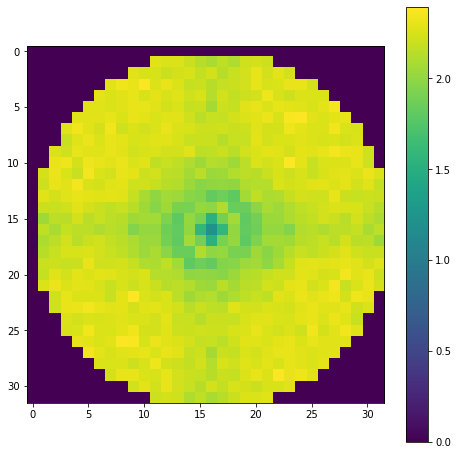

In [248]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [255]:
alpha_idx = 0

1e-07


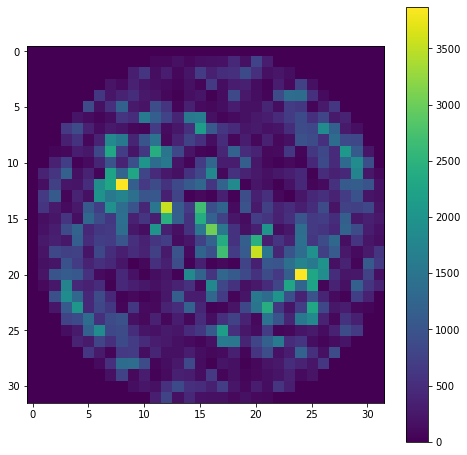

In [256]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

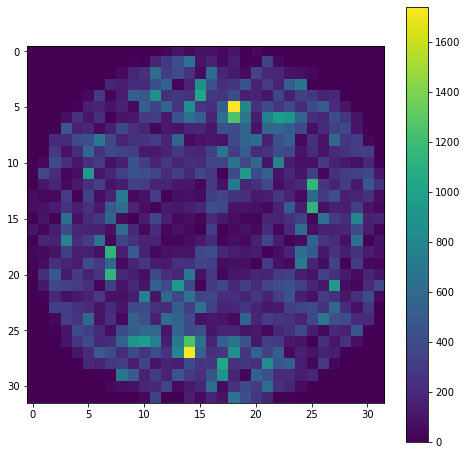

In [257]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_rec[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

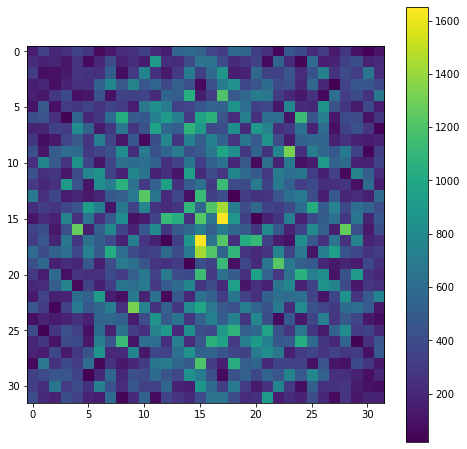

In [258]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

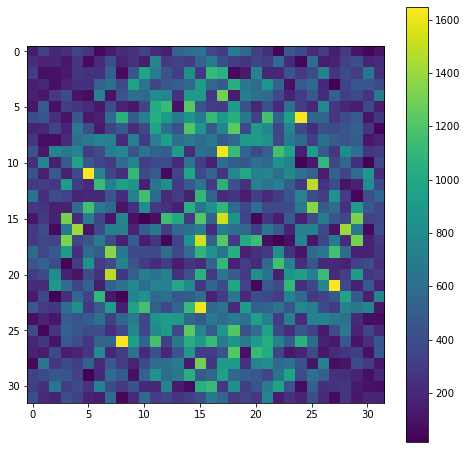

In [270]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

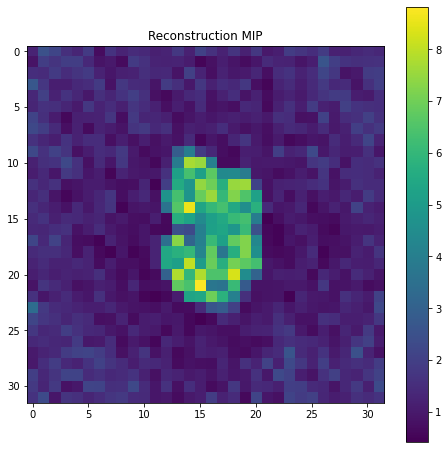

In [259]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

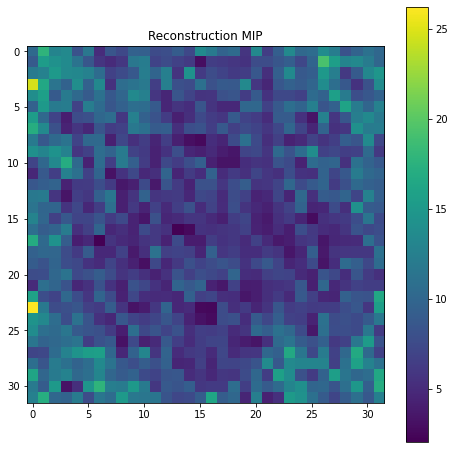

In [260]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')

In [254]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha_angles_rec.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


In [43]:
#points_v_tri = points_orientations_tri(angles[:50], x_grid[1])
points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()

### SGD

### Preconditioner

0.5011371424499267
1.0
0.5011371424499267


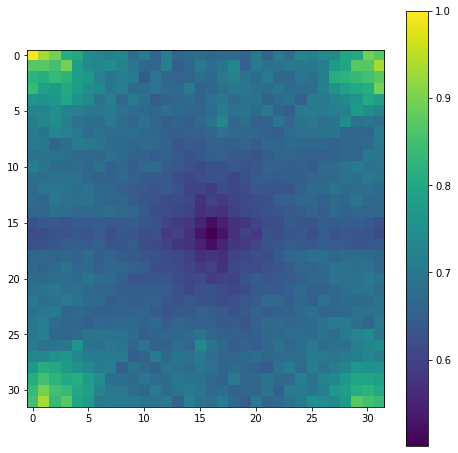

In [54]:
points_v_nn.shape
P2 = points_v_nn
P2 += 1
P2 = (1/P2**0.1 ) * mask

P2 = P2/jnp.max(P2)

plt.imshow(jnp.fft.fftshift(P2[:,:,0]));plt.colorbar()
print(P2[0,0,0])
print(jnp.max(P2))
print(jnp.min(P2))

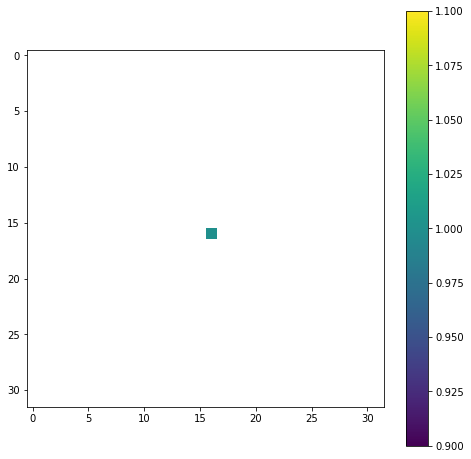

In [103]:
from src.utils import get_sinc

S = get_sinc(x_grid)
plt.imshow(jnp.fft.fftshift(S[:,:,0]));plt.colorbar()



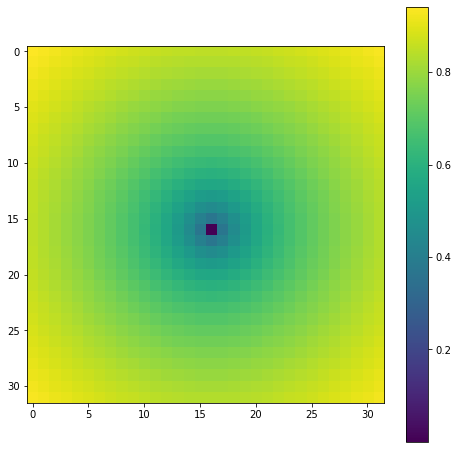

In [69]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

In [70]:
g = sgd_grad_func(v0, jnp.arange(N))
plt.imshow(jnp.fft.fftshift(jnp.abs(g[:,:,0]))) ; plt.colorbar()

NameError: name 'sgd_grad_func' is not defined

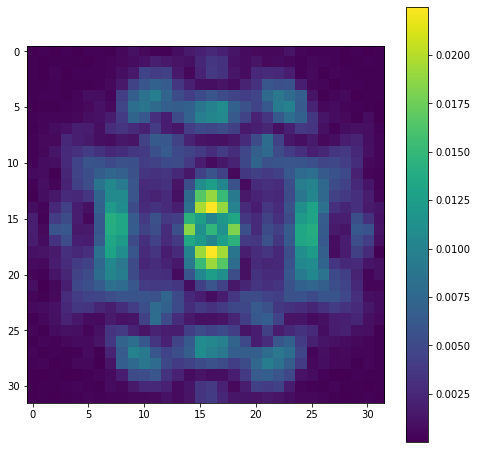

In [33]:
g = sgd_grad_func(v0, jnp.arange(N))
plt.imshow(jnp.fft.fftshift(jnp.abs(g[:,:,0]))) ; plt.colorbar()

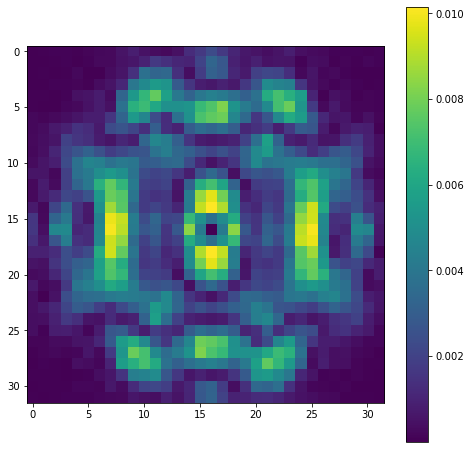

In [39]:
gp = g * P
plt.imshow(jnp.fft.fftshift(jnp.abs(gp[:,:,0]))) ; plt.colorbar()

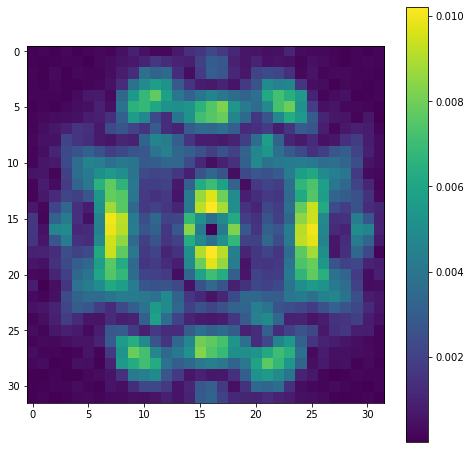

In [35]:
gp = g * P
plt.imshow(jnp.fft.fftshift(jnp.abs(gp[:,:,0]))) ; plt.colorbar()


In [141]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
#v0 = jnp.zeros([nx,nx,nx])* 1j


batch_size = N
N_epoch = 101
number_of_batches = N/batch_size
learning_rate = 10000
#learning_rate = 10000 # <- with normalized precon
P = None


alpha = 1e-6
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_rec, shifts, ctf_params, imgs_f, sigma_noise)

In [142]:
vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, True)
            
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles_rec, shifts, ctf_params, imgs_f, sigma_noise)))
#print("Relative error with CG = ", jnp.max(jnp.abs((vgd - vcg1)/jnp.max(vcg1))))

  sgd epoch 0: mean sampled gradient = 3.6147497047995464e-06
  sgd epoch 50: mean sampled gradient = 1.7369119623034047e-06
  sgd epoch 100: mean sampled gradient = 8.410116529523217e-07
Final loss function (over all data) =  10045740.46015559


In [146]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vgd, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))/(nx*nx))



Final loss function (over all data) =  2.179580852726215


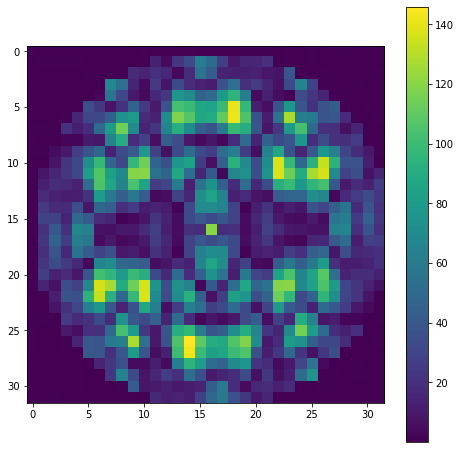

In [144]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgd[:,0,:]))); plt.colorbar()

In [121]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [122]:
err = vgd - v_rec
plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

NameError: name 'v_rec' is not defined

NameError: name 'v_rec' is not defined

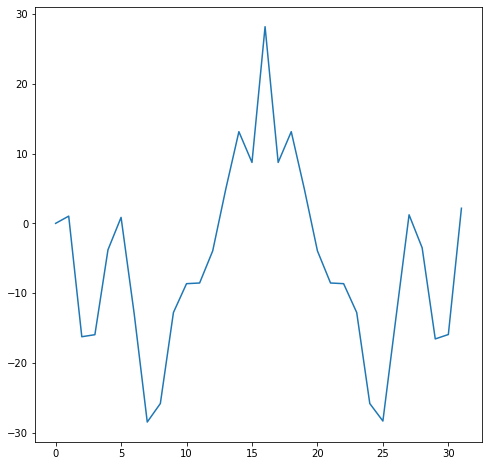

In [123]:
plt.plot(jnp.fft.fftshift(jnp.real(vgd[0,:,0])))
plt.plot(jnp.fft.fftshift(jnp.real(v_rec[0,:,0])))
plt.plot(jnp.fft.fftshift(jnp.real(imgs_f[idx].reshape([32,32])[0,:])))
plt.legend(['vgd', 'vrec', 'img'])

In [147]:
jnp.max(jnp.abs(imgs_f))

DeviceArray(5328.8518801, dtype=float64)

In [148]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgd)))

Text(0.5, 1.0, 'Reconstruction MIP')

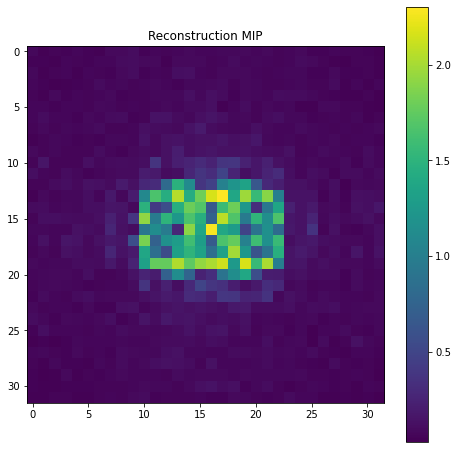

In [149]:
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [59]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

In [109]:
with mrcfile.new('../data/reconstruction_data_32_sgd.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [61]:
idx = 100

In [150]:
slicegd = slice_func(vgd, angles[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles[idx], shifts[idx], ctf_params[idx])

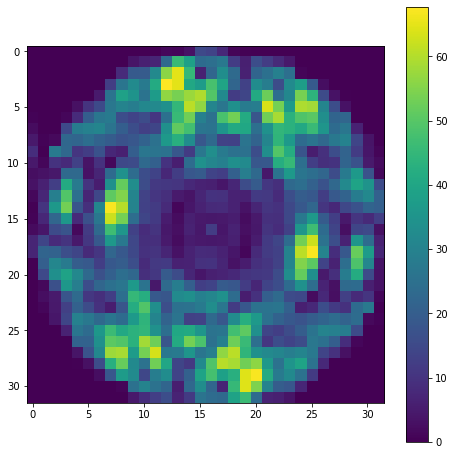

In [151]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([32,32])))); plt.colorbar()

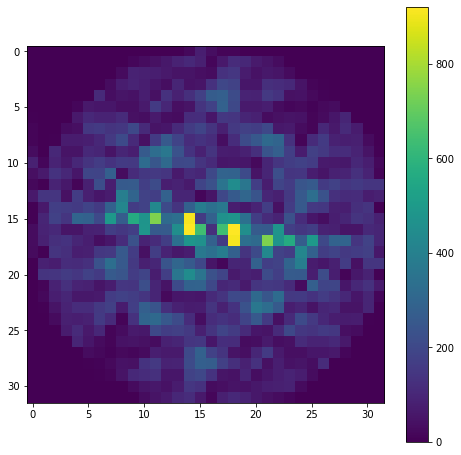

In [559]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

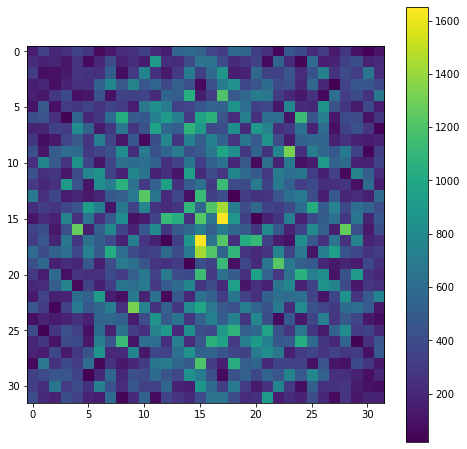

In [113]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [88]:
print(1/2*wl2sq(slicegd, imgs_f[idx], 1/sigma_noise**2))
print(1/2*wl2sq(slicerec, imgs_f[idx], 1/sigma_noise**2))

2328.8634995135394


NameError: name 'slicerec' is not defined

In [76]:
lossgd = loss_func_sum(vgd, angles, shifts, ctf_params, imgs_f, sigma_noise)
lossrec = loss_func_sum(v_rec, angles, shifts, ctf_params, imgs_f, sigma_noise)

print(lossgd)
print(lossrec)

NameError: name 'v_rec' is not defined

In [268]:
alpha0 = 0 

loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
grad_loss_volume0, grad_loss_volume_batched0, grad_loss_volume_sum0 = get_grad_v_funcs(loss_func0, loss_func_sum0)

In [269]:
lossgd0 = loss_func_sum0(vgd, angles, shifts, ctf_params, imgs_f)
lossrec0 = loss_func_sum0(v_rec, angles, shifts, ctf_params, imgs_f)

print(lossgd0)
print(lossrec0)

117666.1786326568
125930.4384133436


In [270]:
reg_term = lambda v, alpha : 1/(2*v.shape[-1]**2) * alpha * l2sq(v)

In [276]:
print(reg_term(vgd, alpha) + lossgd0)
print(reg_term(v_rec, alpha) + lossrec0)

118950.80871989178
324801.5763731515


In [281]:
imgs_f.shape

(4501, 1024)

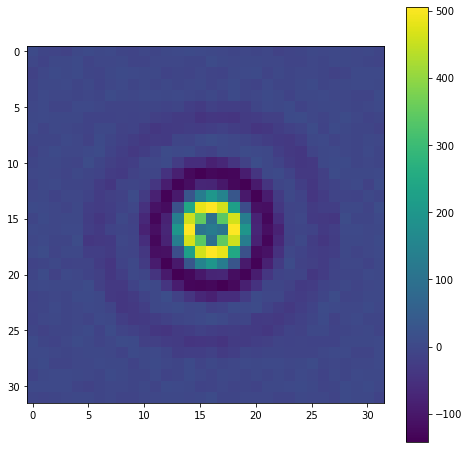

In [395]:
imgs_mean = jnp.mean(jnp.real(imgs_f), axis=0)
plt.imshow(jnp.fft.fftshift((imgs_mean.reshape([32,32]))))
plt.colorbar()

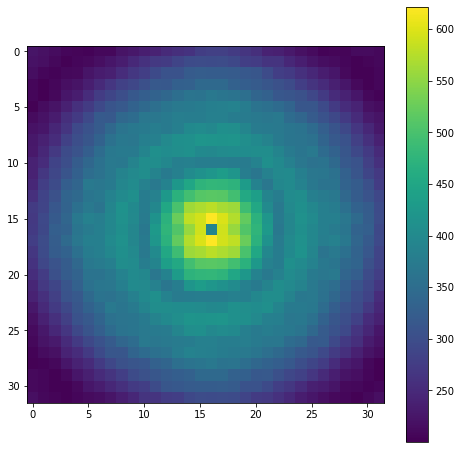

In [373]:
imgs_sd = jnp.sqrt(jnp.mean((jnp.real(imgs_f)-imgs_mean)**2, axis=0))
plt.imshow(jnp.fft.fftshift(imgs_sd.reshape([32,32])))
plt.colorbar()

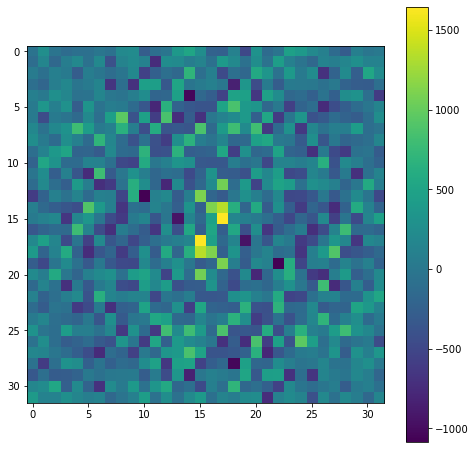

In [397]:
plt.imshow(jnp.real(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [380]:
img_idx = jnp.fft.fftshift(imgs_f[idx].reshape([32,32]))

In [443]:
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))

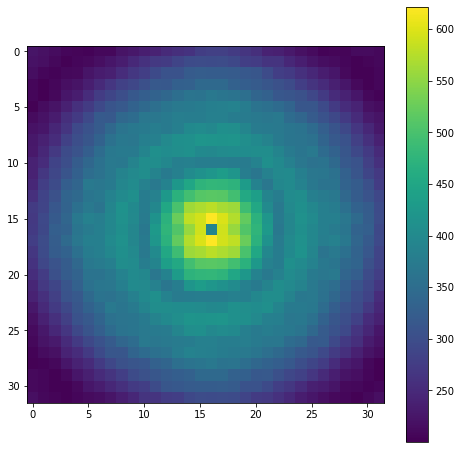

In [437]:
plt.imshow(jnp.fft.fftshift(sd_real.reshape([32,32]))); plt.colorbar()